# Modelo para Produção de Celulase
## Angarita et al. 2015

Tradução do código Scilab para Python

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import pandas as pd

## Dados Experimentais

In [23]:
# Dados experimentais
# 20% sólidos e 10 FPU/g
dados = np.array([
    [1.0, 5.46, 0.00, 2.50],
    [2.0, 5.93, 0.00, 3.30],
    [4.0, 11.87, 0.00, 3.49],
    [6.0, 13.99, 0.00, 3.90],
    [8.0, 22.14, 0.47, 5.64],
    [12.0, 24.47, 0.51, 5.76],
    [24.0, 38.97, 0.96, 8.15],
    [48.0, 51.08, 1.28, 9.29],
    [72.0, 70.66, 2.19, 11.32],
    [96.0, 84.52, 0.11, 11.99]
])

# 10% sólidos e 10FPU/g [tempo G G2 X]
dados1 = np.array([
    [1, 4.30, 0.2295, 2.2004],
    [2, 6.83, 0.2981, 3.2317],
    [6, 15.05, 0.4533, 5.0717],
    [8, 20.49, 0.3853, 4.6835],
    [12, 21.02, 0.5157, 5.6440],
    [24, 23.31, 0.4363, 9.6220],
    [48, 35.19, 0.7423, 8.1657],
    [72, 37.86, 0.5667, 7.3837],
    [96, 38.5, 0.3060, 7.9050]
])

# 15% sólidos e 10FPU/g [tempo G G2 X]
dados2 = np.array([
    [0, 0.0, 0.0, 0.0],
    [1, 8.77, 0.17, 1.43],
    [2, 13.36, 0.37, 2.01],
    [4, 23.09, 0.69, 2.83],
    [6, 28.86, 0.82, 3.20],
    [8, 33.10, 0.92, 3.50],
    [12, 37.27, 1.05, 3.83],
    [24, 45.35, 1.41, 4.46],
    [48, 53.56, 1.08, 7.71],
    [72, 55.91, 0.95, 7.94],
    [96, 57.91, 0.93, 8.36]
])

## Definição dos Parâmetros do Modelo

In [24]:
# Configuração dos dados para o modelo
S0 = 150.0              # Carregamento de sólidos (Palha de cana-de-açúcar pré-tratada)
Cellulose = 0.66        # Conteúdo de celulose (0-1, adimensional)
Hemicellulose = 0.083   # Conteúdo de hemicelulose (0-1, adimensional)
Lignin = 0.257          # Conteúdo de lignina (0-1, adimensional)
Glucose = 0             # Concentração de glicose (g/L)
Cellobiose = 0          # Concentração de celobiose (g/L)
Xylose = 0              # Concentração de xilose (g/L)

alfa = 1.0
E_T = 0.175             # Concentração total de enzima (g/L)

# Parâmetros
k_1r = 0.177
k_2r = 8.81
k_3r = 201.0*0.9
k_4r = 16.34/10

k_11G2 = 0.402
k_11G = 2.71
k_11X = 2.15
k_21G2 = 119.6
k_21G = 4.69
k_21X = 0.095
k_3M = 26.6
k_31G = 11.06
k_31X = 1.023

k_41G2 = 16.25
k_41G = 4.0
k_41X = 154.0

k_ad = 7.16
E_max = 8.32/1000

## Cálculo da Enzima Livre e Adsorvida

In [25]:
def enzyme_equation(E_F, S):
    """Função para calcular o equilíbrio enzimático"""
    E_B = E_T - E_F
    return E_max * k_ad * E_F / (1 + k_ad * E_F) - E_B / S

# Condições iniciais para resolver a equação da enzima
S = S0
E_F_initial = 0.1

# Resolver para E_F
E_F = fsolve(lambda x: enzyme_equation(x, S), E_F_initial)[0]
E_B = E_T - E_F

print(f"Enzima livre inicial (E_F): {E_F:.4f} g/L")
print(f"Enzima adsorvida inicial (E_B): {E_B:.4f} g/L")

Enzima livre inicial (E_F): 0.0198 g/L
Enzima adsorvida inicial (E_B): 0.1552 g/L


## Sistema de Equações Diferenciais

In [26]:
def chemical_system(t, y):
    """Sistema de equações diferenciais para o modelo de hidrólise"""
    
    # Variáveis de estado
    C = y[0]    # Celulose (g/L)
    G2 = y[1]   # Celobiose (g/L)
    G = y[2]    # Glicose (g/L)
    H = y[3]    # Hemicelulose (g/L)
    X = y[4]    # Xilose (g/L)
    S = y[5]    # Biomassa (g/L)
    E_B = y[6]  # Enzima adsorvida na biomassa
    E_F = y[7]  # Enzima livre
    
    # Fator de resistência
    R_S = alfa * S / S0
    
    # Taxas de reação
    r1 = k_1r * (E_B * C / S) * R_S * S / (1 + G2/k_11G2 + G/k_11G + X/k_11X)  # Eq. 5
    r2 = k_2r * (E_B * C / S) * R_S * S / (1 + G2/k_21G2 + G/k_21G + X/k_21X)  # Eq. 6
    r3 = k_3r * E_F * G2 / (k_3M * (1 + G/k_31G + X/k_31X) + G2)              # Eq. 7
    r4 = k_4r * (E_B * H / S) * R_S * S / (1 + G2/k_41G2 + G/k_41G + X/k_41X)  # Eq. 8
    
    # Sistema de equações diferenciais
    dCdt = -r1 - r2                    # Balanço de celulose
    dG2dt = 1.056 * r1 - r3            # Balanço de celobiose
    dGdt = 1.111 * r2 + 1.053 * r3     # Balanço de glicose
    dHdt = -r4                         # Balanço de hemicelulose
    dXdt = 1.136 * r4                  # Balanço de xilose
    dSdt = -r1 - r2 - r4               # Balanço de biomassa
    
    # Equações algébricas para as enzimas (derivadas = 0)
    dE_Bdt = 0
    dE_Fdt = 0
    
    return [dCdt, dG2dt, dGdt, dHdt, dXdt, dSdt, dE_Bdt, dE_Fdt]

## Condições Iniciais e Integração

In [27]:
# Condições iniciais
t0 = 0              # Tempo inicial (h)
tn = 96.0           # Tempo final (h)
t_span = (t0, tn)
t_eval = np.linspace(t0, tn, 97)  # Pontos de avaliação

# Lignina
Lig = Lignin * S0

# Condições iniciais [C, G2, G, H, X, S, E_B, E_F]
y0 = [
    S0 * Cellulose,    # Celulose inicial
    Cellobiose,        # Celobiose inicial
    Glucose,           # Glicose inicial
    S0 * Hemicellulose, # Hemicelulose inicial
    Xylose,            # Xilose inicial
    S0,                # Biomassa inicial
    E_B,               # Enzima adsorvida inicial
    E_F                # Enzima livre inicial
]

print("Condições iniciais:")
print(f"Celulose: {y0[0]:.2f} g/L")
print(f"Celobiose: {y0[1]:.2f} g/L")
print(f"Glicose: {y0[2]:.2f} g/L")
print(f"Hemicelulose: {y0[3]:.2f} g/L")
print(f"Xilose: {y0[4]:.2f} g/L")
print(f"Biomassa: {y0[5]:.2f} g/L")
print(f"Enzima adsorvida: {y0[6]:.4f} g/L")
print(f"Enzima livre: {y0[7]:.4f} g/L")

Condições iniciais:
Celulose: 99.00 g/L
Celobiose: 0.00 g/L
Glicose: 0.00 g/L
Hemicelulose: 12.45 g/L
Xilose: 0.00 g/L
Biomassa: 150.00 g/L
Enzima adsorvida: 0.1552 g/L
Enzima livre: 0.0198 g/L


## Solução do Sistema

In [28]:
# Resolver o sistema de equações diferenciais
sol = solve_ivp(chemical_system, t_span, y0, t_eval=t_eval, method='LSODA', rtol=1e-8)

# Extrair resultados
t_result = sol.t
C_result = sol.y[0]
G2_result = sol.y[1]
G_result = sol.y[2]
H_result = sol.y[3]
X_result = sol.y[4]
S_result = sol.y[5]
EB_result = sol.y[6]
EF_result = sol.y[7]

print(f"Integração concluída. Status: {sol.message}")
print(f"Número de pontos: {len(t_result)}")

Integração concluída. Status: The solver successfully reached the end of the integration interval.
Número de pontos: 97


## Gráficos dos Resultados

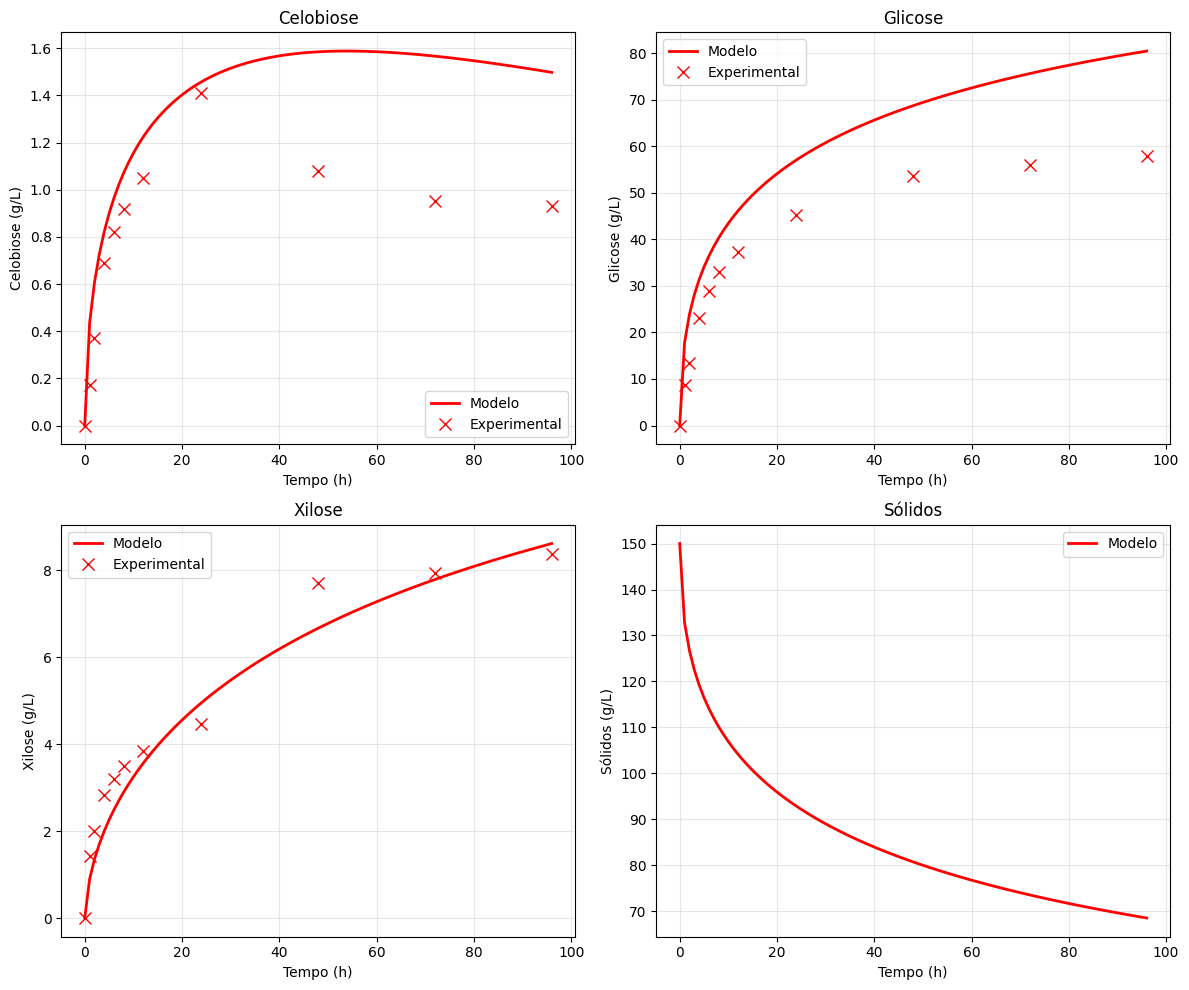

In [29]:
# Criar gráficos
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Gráfico 1: Celobiose
ax1.plot(t_result, G2_result, 'r-', label='Modelo', linewidth=2)
ax1.plot(dados2[:, 0], dados2[:, 2], 'rx', label='Experimental', markersize=8)
ax1.set_xlabel('Tempo (h)')
ax1.set_ylabel('Celobiose (g/L)')
ax1.set_title('Celobiose')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Glicose
ax2.plot(t_result, G_result, 'r-', label='Modelo', linewidth=2)
ax2.plot(dados2[:, 0], dados2[:, 1], 'rx', label='Experimental', markersize=8)
ax2.set_xlabel('Tempo (h)')
ax2.set_ylabel('Glicose (g/L)')
ax2.set_title('Glicose')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfico 3: Xilose
ax3.plot(t_result, X_result, 'r-', label='Modelo', linewidth=2)
ax3.plot(dados2[:, 0], dados2[:, 3], 'rx', label='Experimental', markersize=8)
ax3.set_xlabel('Tempo (h)')
ax3.set_ylabel('Xilose (g/L)')
ax3.set_title('Xilose')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Gráfico 4: Sólidos
ax4.plot(t_result, S_result, 'r-', label='Modelo', linewidth=2)
ax4.set_xlabel('Tempo (h)')
ax4.set_ylabel('Sólidos (g/L)')
ax4.set_title('Sólidos')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Análise dos Resultados

In [30]:
# Criar DataFrame com os resultados
results_df = pd.DataFrame({
    'Tempo (h)': t_result,
    'Celulose (g/L)': C_result,
    'Celobiose (g/L)': G2_result,
    'Glicose (g/L)': G_result,
    'Hemicelulose (g/L)': H_result,
    'Xilose (g/L)': X_result,
    'Sólidos (g/L)': S_result,
    'Enzima Adsorvida (g/L)': EB_result,
    'Enzima Livre (g/L)': EF_result
})

# Mostrar alguns pontos importantes
key_times = [0, 24, 48, 72, 96]
print("Resultados em tempos-chave:")
for time in key_times:
    idx = np.argmin(np.abs(t_result - time))
    print(f"\nTempo: {t_result[idx]:.1f} h")
    print(f"  Glicose: {G_result[idx]:.2f} g/L")
    print(f"  Celobiose: {G2_result[idx]:.2f} g/L")
    print(f"  Xilose: {X_result[idx]:.2f} g/L")
    print(f"  Sólidos: {S_result[idx]:.2f} g/L")

Resultados em tempos-chave:

Tempo: 0.0 h
  Glicose: 0.00 g/L
  Celobiose: 0.00 g/L
  Xilose: 0.00 g/L
  Sólidos: 150.00 g/L

Tempo: 24.0 h
  Glicose: 57.09 g/L
  Celobiose: 1.46 g/L
  Xilose: 4.95 g/L
  Sólidos: 92.88 g/L

Tempo: 48.0 h
  Glicose: 68.76 g/L
  Celobiose: 1.58 g/L
  Xilose: 6.66 g/L
  Sólidos: 80.75 g/L

Tempo: 72.0 h
  Glicose: 75.67 g/L
  Celobiose: 1.57 g/L
  Xilose: 7.78 g/L
  Sólidos: 73.56 g/L

Tempo: 96.0 h
  Glicose: 80.50 g/L
  Celobiose: 1.50 g/L
  Xilose: 8.61 g/L
  Sólidos: 68.55 g/L


## Conversão e Rendimentos

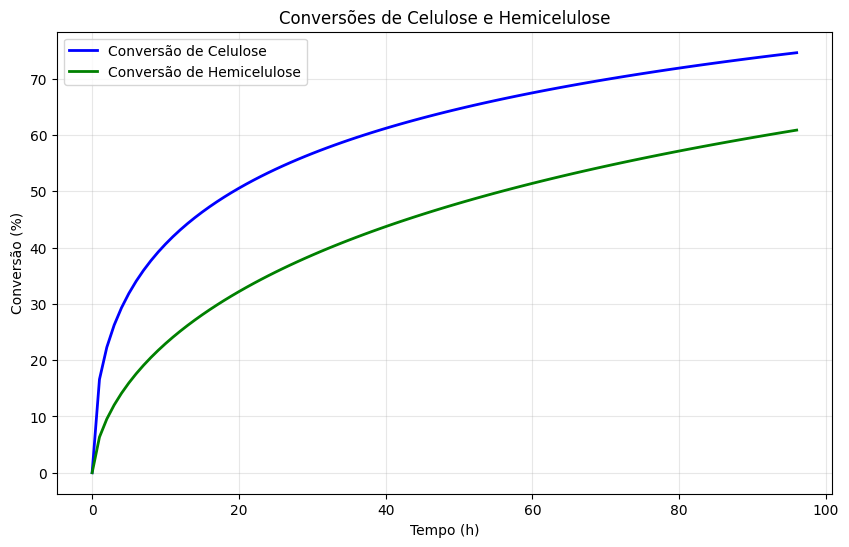

Conversão final de celulose: 74.6%
Conversão final de hemicelulose: 60.9%
Concentração final de glicose: 80.50 g/L
Concentração final de xilose: 8.61 g/L


In [31]:
# Calcular conversões
conversao_celulose = (1 - C_result / (S0 * Cellulose)) * 100
conversao_hemicelulose = (1 - H_result / (S0 * Hemicellulose)) * 100

# Gráfico de conversões
plt.figure(figsize=(10, 6))
plt.plot(t_result, conversao_celulose, 'b-', label='Conversão de Celulose', linewidth=2)
plt.plot(t_result, conversao_hemicelulose, 'g-', label='Conversão de Hemicelulose', linewidth=2)
plt.xlabel('Tempo (h)')
plt.ylabel('Conversão (%)')
plt.title('Conversões de Celulose e Hemicelulose')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Conversão final de celulose: {conversao_celulose[-1]:.1f}%")
print(f"Conversão final de hemicelulose: {conversao_hemicelulose[-1]:.1f}%")
print(f"Concentração final de glicose: {G_result[-1]:.2f} g/L")
print(f"Concentração final de xilose: {X_result[-1]:.2f} g/L")